In [1]:
# importing libraries & modules
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

## Loading stock data
---

In [2]:
google = yf.Ticker("GOOGL")
google_data = google.history(period="1y")

## Visualizing stock price data over time
---

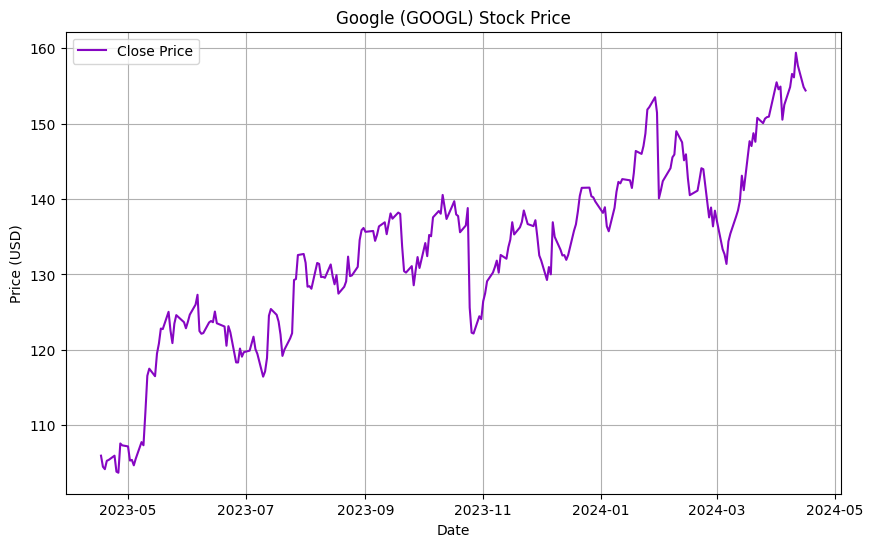

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(google_data['Close'], label='Close Price', color='#8606c2')
plt.title('Google (GOOGL) Stock Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
close_price = google_data['Close']

In [5]:
close_price.shift(1)

Date
2023-04-17 00:00:00-04:00           NaN
2023-04-18 00:00:00-04:00    105.970001
2023-04-19 00:00:00-04:00    104.500000
2023-04-20 00:00:00-04:00    104.180000
2023-04-21 00:00:00-04:00    105.290001
                                ...    
2024-04-10 00:00:00-04:00    156.600006
2024-04-11 00:00:00-04:00    156.139999
2024-04-12 00:00:00-04:00    159.410004
2024-04-15 00:00:00-04:00    157.729996
2024-04-16 00:00:00-04:00    154.860001
Name: Close, Length: 252, dtype: float64

In [6]:
returns = ((close_price - close_price.shift(1)) / close_price.shift(1)).dropna()
annual_volatility = np.std(returns) * np.sqrt(252)

print(f'Annual Volatility : {annual_volatility}')

Annual Volatility : 0.2700090212148999


##  Using 10 years' US treasury rate as the rate of interest
---

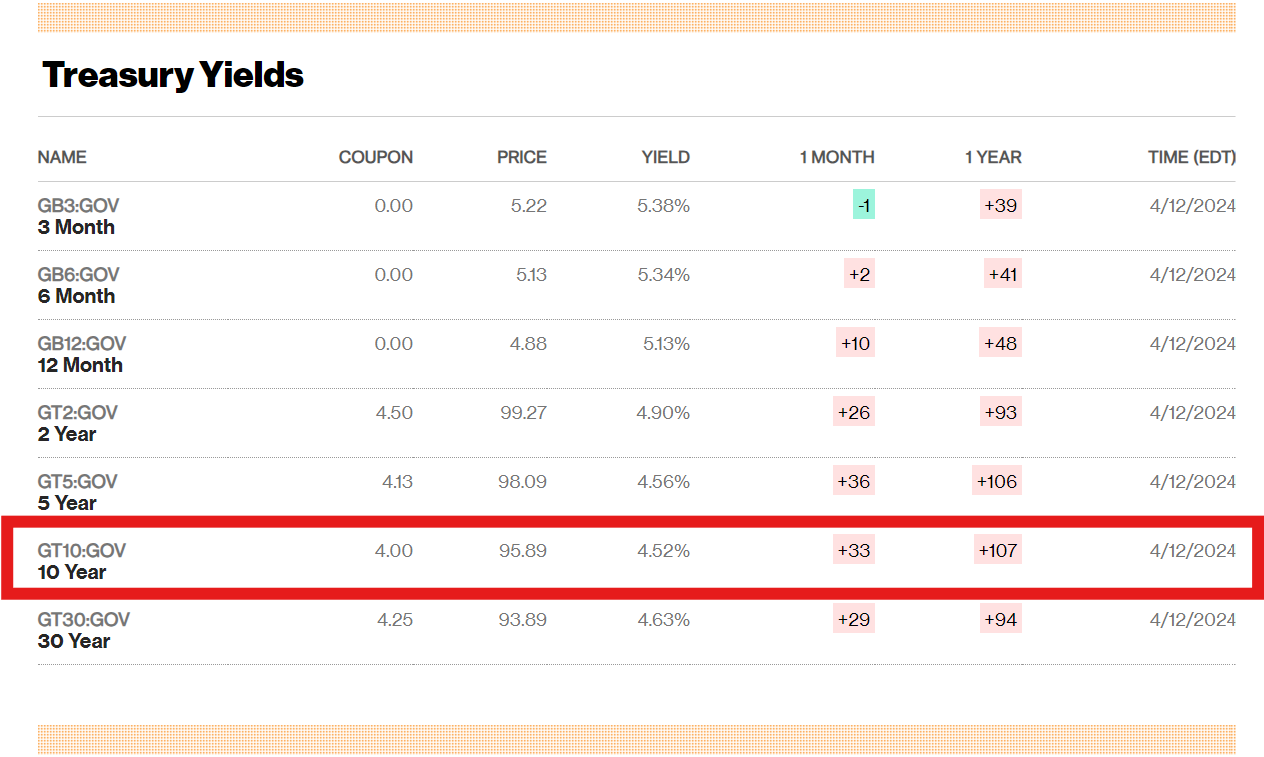

In [7]:
rate_of_interest = 4.52 / 100

In [8]:
def put_call_parity(C0, K, T, r, S0):
    '''
    returns put option price based on put-call parity
    '''
    P0 = C0 - S0 + K * np.exp(-r * T)
    return P0

## Evaluating the call / put option prices by using Binomial model
---

In [9]:
def binomial_option_pricing(S0, K, T, r, σ, n, option_type):
    """
    Calculates the option price using the Binomial option pricing model.
    -----------------
    
    Args:
        S0 (float): Current stock price
        K (float): Strike price
        T (float): Time to maturity in years
        r (float): Risk-free interest rate
        σ (float): Annual volatility of the underlying asset
        n (int): Number of time steps
        option_type (str): 'call' or 'put'
        
    Returns:
        float: Option price
    """
    
    Δt = T / n
    u = math.exp(σ * math.sqrt(Δt))
    d = 1 / u
    p = (math.exp(r * Δt) - d) / (u - d)
    
    option_price = 0
    
    for j in range(0, n + 1):
        price_component = S0 * (u ** j) * (d ** (n - j)) - K
        prob_component = math.comb(n, j) * (p ** j) * ((1 - p) ** (n - j))
     
        if option_type == 'call':
            price = prob_component * max(0, price_component)
        elif option_type == 'put':
            price = prob_component * max(0, -price_component)
        
        option_price += price
        
    option_price = math.exp(-r * T) * option_price
    return option_price

In [10]:
S0 = google_data['Close'][0]    # current stock price
σ = annual_volatility    # annual volatility
r = rate_of_interest    # interest rate
n = 2    # number of time steps
T = 1
K = 100

In [11]:
call_option_price = binomial_option_pricing(S0, K, T, r, σ, n, 'call')
print(f'Call option price using Binomial model : {call_option_price}')

Call option price using Binomial model : 16.688819547008457


In [12]:
put_option_price = binomial_option_pricing(S0, K, T, r, σ, n, 'put')
print(f'Put option price using Binomial model : {put_option_price}')

Put option price using Binomial model : 6.2994484718461585


In [13]:
C0, K, T, r, S0 = call_option_price, K, T, r, S0
put_option_price = put_call_parity(C0, K, T, r, S0)
print(f'Put option price using put call parity : {put_option_price}')

Put option price using put call parity : 6.299448471846162


## Evaluating the call / put option prices by using Black Scholes formula
---

In [14]:
def black_scholes_formula(S0, K, T, r, σ, option_type):
    '''
    Calculates the option price using the Black Scholes formula.
    -----------------
    
    Args:
        S0 (float): Current stock price
        K (float): Strike price
        T (float): Time to maturity in years
        r (float): Risk-free interest rate
        σ (float): Annual volatility of the underlying asset
        option_type (str): 'call' or 'put'
        
    Returns:
        float: Option price
    '''
    d1 = (math.log(S0 / K) + (r + (σ ** 2) / 2) * T) / (σ * math.sqrt(T))
    d2 = d1 - σ * math.sqrt(T)
    
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    C0 = S0 * N_d1 - K * math.exp(-r * T) * N_d2
    if option_type == 'call':
        return C0
    elif option_type == 'put':
        P0 = put_call_parity(C0, K, T, r, S0)
        return P0

In [15]:
S0 = google_data['Close'][0]    # current stock price
σ = annual_volatility    # annual volatility
r = rate_of_interest    # interest rate
T = 1
K = 100

In [16]:
call_option_price = black_scholes_formula(S0, K, T, r, σ, 'call')
print(f'Call option price using Black Scholes formula : {call_option_price}')

Call option price using Black Scholes formula : 16.79232304898749


In [17]:
put_option_price = black_scholes_formula(S0, K, T, r, σ, 'put')
print(f'Put option price using Black Scholes formula : {put_option_price}')

Put option price using Black Scholes formula : 6.4029519738252105


## Evaluating option prices
---

In [18]:
K_vals = S0 + np.arange(-20, 20)
T_vals = [num_months * (1 / 12) for num_months in range(1, 13, 4)]

S0 = google_data['Close'][0]    # current stock price
σ = annual_volatility    # annual volatility
r = rate_of_interest    # interest rate
n = 2    # number of time steps

for K in K_vals:
    print(f'For K = {K}')
    for T in T_vals:
        call_option_price = binomial_option_pricing(S0, K, T, r, σ, n, 'call')
        print(f'T = {int(T * 12)} month(s) : Call Option price is {call_option_price}')

For K = 85.97000122070312
T = 1 month(s) : Call Option price is 20.323211241289542
T = 5 month(s) : Call Option price is 22.35363834133577
T = 9 month(s) : Call Option price is 25.146984332504555
For K = 86.97000122070312
T = 1 month(s) : Call Option price is 19.326970822965713
T = 5 month(s) : Call Option price is 21.610310800779427
T = 9 month(s) : Call Option price is 24.412208997155854
For K = 87.97000122070312
T = 1 month(s) : Call Option price is 18.330730404641876
T = 5 month(s) : Call Option price is 20.866983260223087
T = 9 month(s) : Call Option price is 23.677433661807154
For K = 88.97000122070312
T = 1 month(s) : Call Option price is 17.334489986318047
T = 5 month(s) : Call Option price is 20.12365571966674
T = 9 month(s) : Call Option price is 22.942658326458456
For K = 89.97000122070312
T = 1 month(s) : Call Option price is 16.338249567994215
T = 5 month(s) : Call Option price is 19.380328179110393
T = 9 month(s) : Call Option price is 22.20788299110976
For K = 90.9700012

In [19]:
K_vals = S0 + np.arange(-20, 20)
T_vals = [num_months * (1 / 12) for num_months in range(1, 13, 4)]

S0 = google_data['Close'][0]    # current stock price
σ = annual_volatility    # annual volatility
r = rate_of_interest    # interest rate
n = 2    # number of time steps

for K in K_vals:
    print(f'For K = {K}')
    for T in T_vals:
        put_option_price = binomial_option_pricing(S0, K, T, r, σ, n,'put')
        print(f'T = {int(T * 12)} month(s) : Put Option price is {put_option_price}')

For K = 85.97000122070312
T = 1 month(s) : Put Option price is 0.0
T = 5 month(s) : Put Option price is 0.7496879271575465
T = 9 month(s) : Put Option price is 2.2814465762226885
For K = 86.97000122070312
T = 1 month(s) : Put Option price is 0.0
T = 5 month(s) : Put Option price is 0.9877032923659641
T = 9 month(s) : Put Option price is 2.513339407494979
For K = 87.97000122070312
T = 1 month(s) : Put Option price is 0.0
T = 5 month(s) : Put Option price is 1.225718657574382
T = 9 month(s) : Put Option price is 2.745232238767269
For K = 88.97000122070312
T = 1 month(s) : Put Option price is 0.0
T = 5 month(s) : Put Option price is 1.4637340227827993
T = 9 month(s) : Put Option price is 2.9771250700395595
For K = 89.97000122070312
T = 1 month(s) : Put Option price is 0.0
T = 5 month(s) : Put Option price is 1.7017493879912169
T = 9 month(s) : Put Option price is 3.2090179013118503
For K = 90.97000122070312
T = 1 month(s) : Put Option price is 0.0
T = 5 month(s) : Put Option price is 1.93

In [20]:
K_vals = S0 + np.arange(-20, 20)
T_vals = [num_months * (1 / 12) for num_months in range(1, 13, 4)]

S0 = google_data['Close'][0]    # current stock price
σ = annual_volatility    # annual volatility
r = rate_of_interest    # interest rate

for K in K_vals:
    print(f'For K = {K}')
    for T in T_vals:
        call_option_price = black_scholes_formula(S0, K, T, r, σ, 'call')
        print(f'T = {int(T * 12)} month(s) : Put Option price is {call_option_price}')

For K = 85.97000122070312
T = 1 month(s) : Put Option price is 20.330299662395632
T = 5 month(s) : Put Option price is 22.339450096210143
T = 9 month(s) : Put Option price is 24.553126754639777
For K = 86.97000122070312
T = 1 month(s) : Put Option price is 19.33849044686029
T = 5 month(s) : Put Option price is 21.473428304882802
T = 9 month(s) : Put Option price is 23.764986919375474
For K = 87.97000122070312
T = 1 month(s) : Put Option price is 18.349004848234443
T = 5 month(s) : Put Option price is 20.620667316422256
T = 9 month(s) : Put Option price is 22.989798714596517
For K = 88.97000122070312
T = 1 month(s) : Put Option price is 17.36281527734232
T = 5 month(s) : Put Option price is 19.782016945149294
T = 9 month(s) : Put Option price is 22.227957268515226
For K = 89.97000122070312
T = 1 month(s) : Put Option price is 16.38118578558199
T = 5 month(s) : Put Option price is 18.958307661311252
T = 9 month(s) : Put Option price is 21.479832836460616
For K = 90.97000122070312
T = 1 m

In [21]:
K_vals = S0 + np.arange(-20, 20)
T_vals = [num_months * (1 / 12) for num_months in range(1, 13, 4)]

S0 = google_data['Close'][0]    # current stock price
σ = annual_volatility    # annual volatility
r = rate_of_interest    # interest rate

for K in K_vals:
    print(f'For K = {K}')
    for T in T_vals:
        put_option_price = black_scholes_formula(S0, K, T, r, σ, 'put')
        print(f'T = {int(T * 12)} month(s) : Put Option price is {put_option_price}')

For K = 85.97000122070312
T = 1 month(s) : Put Option price is 0.007088421106104192
T = 5 month(s) : Put Option price is 0.7354996820319144
T = 9 month(s) : Put Option price is 1.6875889983579384
For K = 86.97000122070312
T = 1 month(s) : Put Option price is 0.011519623894585607
T = 5 month(s) : Put Option price is 0.8508207964693355
T = 9 month(s) : Put Option price is 1.8661173297146263
For K = 87.97000122070312
T = 1 month(s) : Put Option price is 0.01827444359257413
T = 5 month(s) : Put Option price is 0.9794027137735526
T = 9 month(s) : Put Option price is 2.057597291556661
For K = 88.97000122070312
T = 1 month(s) : Put Option price is 0.028325291024287935
T = 5 month(s) : Put Option price is 1.122095248265353
T = 9 month(s) : Put Option price is 2.2624240120963464
For K = 89.97000122070312
T = 1 month(s) : Put Option price is 0.04293621758777988
T = 5 month(s) : Put Option price is 1.2797288701920735
T = 9 month(s) : Put Option price is 2.480967746662728
For K = 90.97000122070312

In [22]:
S0 = 200    # current stock price
σ = annual_volatility    # annual volatility
r = rate_of_interest    # interest rate
T = 2
K = 220

black_scholes_call_price = black_scholes_formula(S0, K, T, r, σ, 'call')
print(f'Black Scholes Call Option Price : {black_scholes_call_price}')

call_prices = []

for n in range(1, 100):
    call_price = binomial_option_pricing(S0, K, T, r, σ, n, 'call')
    call_prices.append(call_price)

Black Scholes Call Option Price : 29.867946954782212


## Increasing the number of steps in Binomial model to verify that the price converges to that of Black Scholes
---

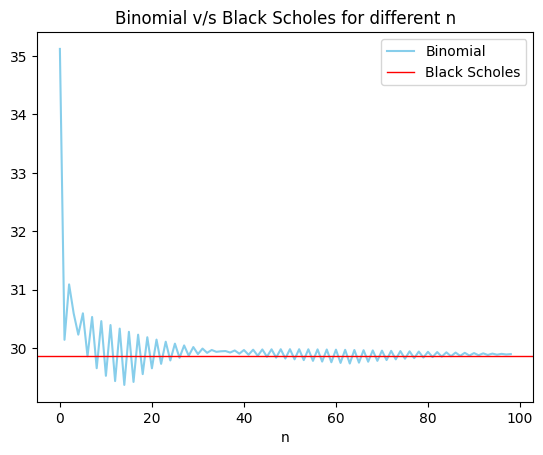

In [23]:
plt.plot(call_prices, label='Binomial', color='skyblue')
plt.axhline(black_scholes_call_price, color='red', label='Black Scholes', linewidth=1)
plt.xlabel('n')

plt.title('Binomial v/s Black Scholes for different n')
plt.legend()
plt.show()

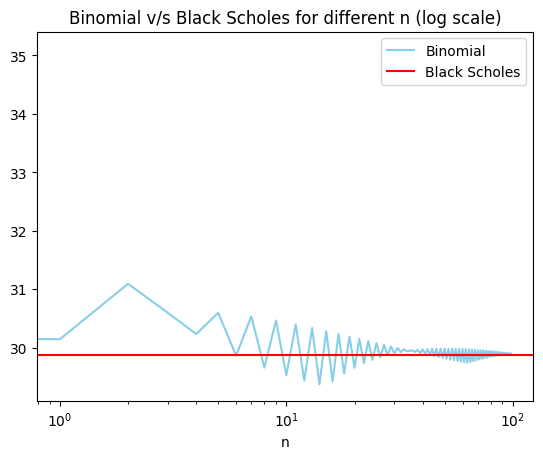

In [24]:
plt.plot(call_prices, label='Binomial', color='skyblue')
plt.axhline(black_scholes_call_price, color='red', label='Black Scholes')
plt.xlabel('n')

plt.legend()
plt.xscale('log')
plt.title('Binomial v/s Black Scholes for different n (log scale)')
plt.show()

## Comparison with actual market data
---

In [25]:
ticker_symbol = "AAPL"
options_data = yf.Ticker(ticker_symbol).options
expiry_date = options_data[0]
options_chain = yf.Ticker(ticker_symbol).option_chain(expiry_date)

calls = pd.DataFrame(options_chain.calls)
puts = pd.DataFrame(options_chain.puts)

In [26]:
try:
    calls.drop(['contractSymbol' , 'bid' , 'ask' , 'change' , 'percentChange' , 'volume' , 'openInterest' , 'inTheMoney'],axis=1 , inplace=True)
    puts.drop(['contractSymbol' , 'bid' , 'ask' , 'change' , 'percentChange' , 'volume' , 'openInterest' , 'inTheMoney'], axis=1 , inplace=True)
except Exception as e:
    print(e)

### Call Option Comparison

In [27]:
calls.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency
0,2024-04-16 16:14:01+00:00,5.0,164.30,0.00001,REGULAR,USD
1,2024-03-27 19:35:59+00:00,10.0,163.00,0.00001,REGULAR,USD
2,2024-04-04 14:55:59+00:00,15.0,155.95,0.00001,REGULAR,USD
3,2024-03-27 15:14:12+00:00,30.0,142.65,0.00001,REGULAR,USD
4,2024-04-12 14:02:42+00:00,35.0,142.43,0.00001,REGULAR,USD


In [28]:
calls['lastTradeDate'] = pd.to_datetime(calls['lastTradeDate']).dt.date
start_date, end_date = "2023-03-28", "2024-04-01"
calls = calls[(calls['lastTradeDate'] >= pd.to_datetime(start_date).date()) & (calls['lastTradeDate'] <= pd.to_datetime(end_date).date())]
calls.reset_index(inplace = True, drop = True)
calls.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency
0,2024-03-27,10.0,163.00,0.000010,REGULAR,USD
1,2024-03-27,30.0,142.65,0.000010,REGULAR,USD
2,2024-03-14,55.0,118.80,11.791995,REGULAR,USD
3,2024-03-27,60.0,112.60,0.000010,REGULAR,USD
4,2024-03-13,70.0,101.60,9.387699,REGULAR,USD


In [29]:
google_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-04-17 00:00:00-04:00,104.660004,106.160004,104.519997,105.970001,37571200,0.0,0.0
2023-04-18 00:00:00-04:00,106.489998,106.540001,104.070000,104.500000,26596400,0.0,0.0
2023-04-19 00:00:00-04:00,103.580002,104.980003,103.070000,104.180000,20905700,0.0,0.0
2023-04-20 00:00:00-04:00,103.910004,106.250000,103.870003,105.290001,27820800,0.0,0.0
2023-04-21 00:00:00-04:00,105.470001,106.000000,104.779999,105.410004,25800100,0.0,0.0


In [30]:
google_data.index = pd.to_datetime(google_data.index)
google_data.index = google_data.index.strftime("%Y-%m-%d")
google_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-04-17,104.660004,106.160004,104.519997,105.970001,37571200,0.0,0.0
2023-04-18,106.489998,106.540001,104.070000,104.500000,26596400,0.0,0.0
2023-04-19,103.580002,104.980003,103.070000,104.180000,20905700,0.0,0.0
2023-04-20,103.910004,106.250000,103.870003,105.290001,27820800,0.0,0.0
2023-04-21,105.470001,106.000000,104.779999,105.410004,25800100,0.0,0.0


In [31]:
expiry_date = pd.to_datetime(expiry_date).date()
expiry_date

datetime.date(2024, 4, 19)

In [32]:
initialPrice_call = []
for date in calls['lastTradeDate']:
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initialPrice = google_data.loc[date, 'Close']
    initialPrice_call.append(initialPrice)
calls['initialPrice'] = initialPrice_call

In [33]:
calls.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initialPrice
0,2024-03-27,10.0,163.00,0.000010,REGULAR,USD,150.869995
1,2024-03-27,30.0,142.65,0.000010,REGULAR,USD,150.869995
2,2024-03-14,55.0,118.80,11.791995,REGULAR,USD,143.100006
3,2024-03-27,60.0,112.60,0.000010,REGULAR,USD,150.869995
4,2024-03-13,70.0,101.60,9.387699,REGULAR,USD,139.789993


In [34]:
maturity_periods_call = []
for i in calls['lastTradeDate']:
    maturity_period = (expiry_date - i ).days
    maturity_periods_call.append(maturity_period)

In [35]:
calls['maturityPeriod'] = maturity_periods_call
calls.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initialPrice,maturityPeriod
0,2024-03-27,10.0,163.00,0.000010,REGULAR,USD,150.869995,23
1,2024-03-27,30.0,142.65,0.000010,REGULAR,USD,150.869995,23
2,2024-03-14,55.0,118.80,11.791995,REGULAR,USD,143.100006,36
3,2024-03-27,60.0,112.60,0.000010,REGULAR,USD,150.869995,23
4,2024-03-13,70.0,101.60,9.387699,REGULAR,USD,139.789993,37


In [36]:
option_price_binomial = []
for i in range(len(calls)):
    T = calls['maturityPeriod'][i]/365
    n = calls['maturityPeriod'][i]
    K = calls['strike'][i]
    S0 = calls['initialPrice'][i]
    op_price = binomial_option_pricing(S0, K, T, r, σ, n, "call")
    option_price_binomial.append(op_price)

In [37]:
calls['optionPriceBinomial'] = option_price_binomial
calls

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initialPrice,maturityPeriod,optionPriceBinomial
0,2024-03-27,10.0,163.00,0.000010,REGULAR,USD,150.869995,23,1.408984e+02
1,2024-03-27,30.0,142.65,0.000010,REGULAR,USD,150.869995,23,1.209553e+02
2,2024-03-14,55.0,118.80,11.791995,REGULAR,USD,143.100006,36,8.834465e+01
3,2024-03-27,60.0,112.60,0.000010,REGULAR,USD,150.869995,23,9.104065e+01
4,2024-03-13,70.0,101.60,9.387699,REGULAR,USD,139.789993,37,7.010999e+01
5,2024-02-14,90.0,94.81,5.730472,REGULAR,USD,145.940002,65,5.666155e+01
6,2024-03-14,255.0,0.02,1.406253,REGULAR,USD,143.100006,36,0.000000e+00
7,2024-03-18,265.0,0.01,0.500005,REGULAR,USD,147.679993,32,0.000000e+00
8,2024-03-28,270.0,0.01,0.500005,REGULAR,USD,150.929993,22,0.000000e+00
9,2024-03-21,275.0,0.01,0.500005,REGULAR,USD,147.600006,29,0.000000e+00


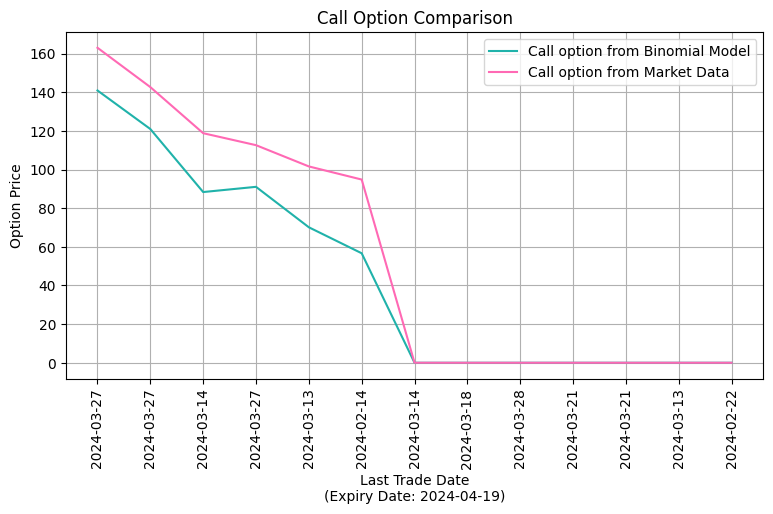

In [38]:
plt.figure(figsize=(9, 4.5))
plt.plot(calls.index, calls['optionPriceBinomial'], label='Call option from Binomial Model', c='lightseagreen')
plt.plot(calls.index, calls['lastPrice'], label='Call option from Market Data', c='hotpink')
plt.title('Call Option Comparison')
plt.ylabel('Option Price')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(calls.index, calls.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

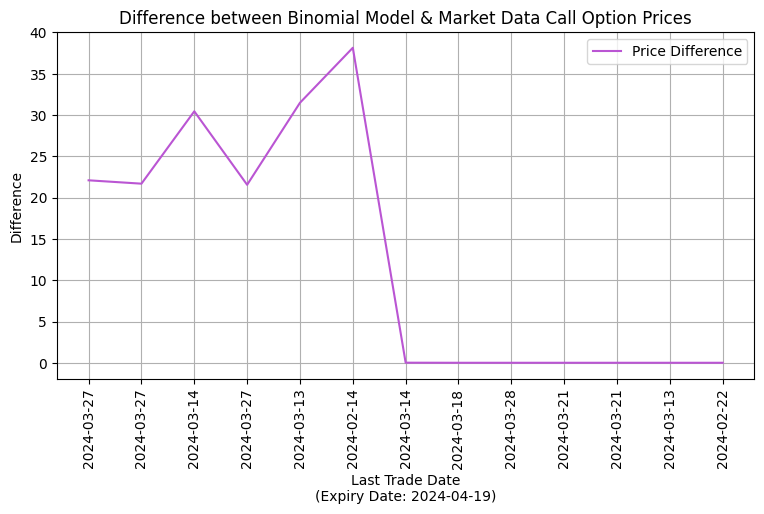

In [39]:
plt.figure(figsize=(9, 4.5))
differences = abs(calls['optionPriceBinomial'] - calls['lastPrice'])
plt.plot(range(len(calls)), differences, label='Price Difference', c='mediumorchid')
plt.title('Difference between Binomial Model & Market Data Call Option Prices')
plt.ylabel('Difference')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(calls.index, calls.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

In [40]:
option_price_black_scholes = []
for i in range(len(calls)):
    T = calls['maturityPeriod'][i]/365
    n = calls['maturityPeriod'][i]
    K = calls['strike'][i]
    S0 = calls['initialPrice'][i]
    op_price = black_scholes_formula(S0, K, T, r, σ, "call")
    option_price_black_scholes.append(op_price)

In [41]:
calls['optionPriceBlackScholes'] = option_price_black_scholes
calls.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initialPrice,maturityPeriod,optionPriceBinomial,optionPriceBlackScholes
0,2024-03-27,10.0,163.00,0.000010,REGULAR,USD,150.869995,23,140.898437,140.898437
1,2024-03-27,30.0,142.65,0.000010,REGULAR,USD,150.869995,23,120.955320,120.955320
2,2024-03-14,55.0,118.80,11.791995,REGULAR,USD,143.100006,36,88.344655,88.344655
3,2024-03-27,60.0,112.60,0.000010,REGULAR,USD,150.869995,23,91.040645,91.040645
4,2024-03-13,70.0,101.60,9.387699,REGULAR,USD,139.789993,37,70.109994,70.109994


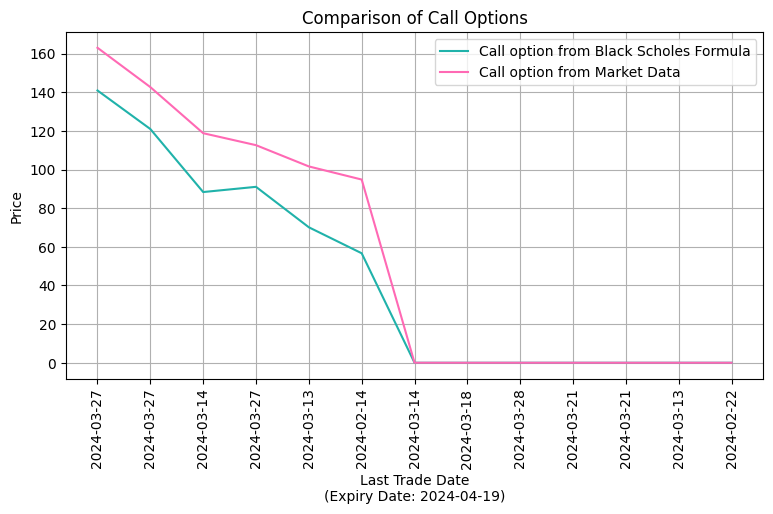

In [42]:
plt.figure(figsize=(9, 4.5))
plt.plot(calls.index, calls['optionPriceBlackScholes'], label='Call option from Black Scholes Formula', c='lightseagreen')
plt.plot(calls.index, calls['lastPrice'], label='Call option from Market Data', c='hotpink')
plt.title('Comparison of Call Options')
plt.ylabel('Price')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(calls.index, calls.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

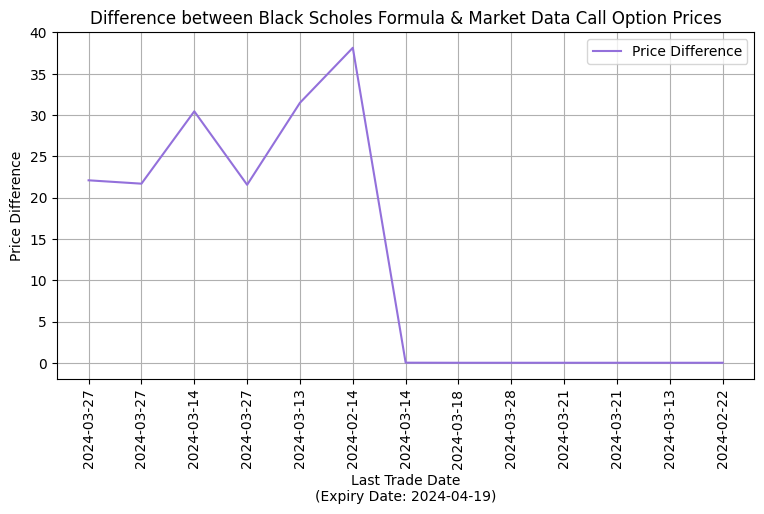

In [43]:
plt.figure(figsize=(9, 4.5))
differences = abs(calls['optionPriceBlackScholes'] - calls['lastPrice'])
plt.plot(calls.index, differences, label='Price Difference', c='mediumpurple')
plt.title('Difference between Black Scholes Formula & Market Data Call Option Prices')
plt.ylabel('Price Difference')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(calls.index, calls.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

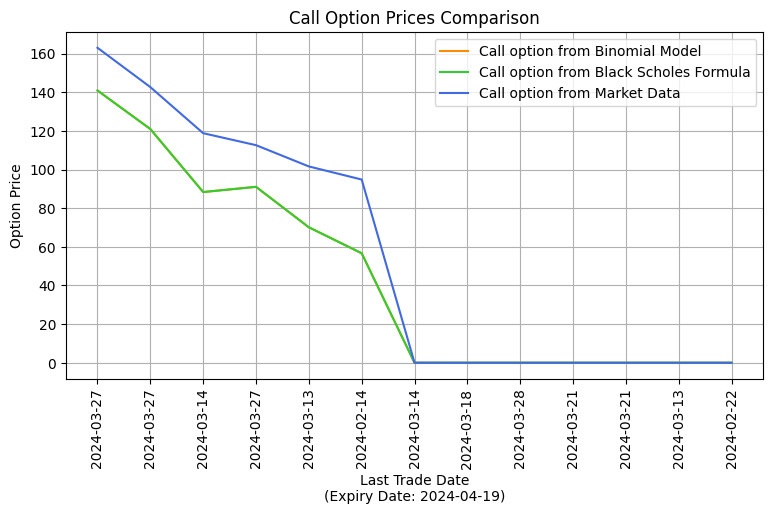

In [44]:
plt.figure(figsize=(9, 4.5))
plt.plot(calls.index, calls['optionPriceBinomial'], label='Call option from Binomial Model', c='darkorange')
plt.plot(calls.index, calls['optionPriceBlackScholes'], label='Call option from Black Scholes Formula', c='limegreen')
plt.plot(calls.index, calls['lastPrice'], label='Call option from Market Data', c='royalblue')
plt.title('Call Option Prices Comparison')
plt.ylabel('Option Price')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(calls.index, calls.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

## Put Option Comparison

In [45]:
puts['lastTradeDate'] = pd.to_datetime(puts['lastTradeDate']).dt.date
start_date = "2023-03-28"
end_date = "2024-04-01"
puts = puts[(puts['lastTradeDate'] >= pd.to_datetime(start_date).date()) & (puts['lastTradeDate'] <= pd.to_datetime(end_date).date())]
puts.reset_index(inplace = True, drop = True)
puts.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency
0,2024-02-20,20.0,0.01,0.500005,REGULAR,USD
1,2024-02-20,65.0,0.01,3.437501,REGULAR,USD
2,2024-03-22,70.0,0.01,0.500005,REGULAR,USD
3,2024-03-15,75.0,0.01,2.750003,REGULAR,USD
4,2024-03-05,85.0,0.02,2.531254,REGULAR,USD


In [46]:
initialPrice_put = []
for date in puts['lastTradeDate']:
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initialPrice = google_data.loc[date, 'Close']
    initialPrice_put.append(initialPrice)
puts['initialPrice'] = initialPrice_put

In [47]:
maturity_periods_put = []
for i in puts['lastTradeDate']:
    maturity_period = (expiry_date - i ).days
    maturity_periods_put.append(maturity_period )

In [48]:
puts['maturityPeriod'] = maturity_periods_put
puts.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initialPrice,maturityPeriod
0,2024-02-20,20.0,0.01,0.500005,REGULAR,USD,141.119995,59
1,2024-02-20,65.0,0.01,3.437501,REGULAR,USD,141.119995,59
2,2024-03-22,70.0,0.01,0.500005,REGULAR,USD,150.770004,28
3,2024-03-15,75.0,0.01,2.750003,REGULAR,USD,141.179993,35
4,2024-03-05,85.0,0.02,2.531254,REGULAR,USD,132.669998,45


In [49]:
option_price_binomial = []
for i in range(len(puts)):
    T = puts['maturityPeriod'][i]/365
    n = puts['maturityPeriod'][i]
    K = puts['strike'][i]
    S0 = puts['initialPrice'][i]
    op_price = binomial_option_pricing(S0, K, T, r, σ, n, "put")
    option_price_binomial.append(op_price)

In [50]:
puts['optionPriceBinomial'] = option_price_binomial
puts

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initialPrice,maturityPeriod,optionPriceBinomial
0,2024-02-20,20.0,0.01,0.500005,REGULAR,USD,141.119995,59,0.000000e+00
1,2024-02-20,65.0,0.01,3.437501,REGULAR,USD,141.119995,59,5.487347e-16
2,2024-03-22,70.0,0.01,0.500005,REGULAR,USD,150.770004,28,0.000000e+00
3,2024-03-15,75.0,0.01,2.750003,REGULAR,USD,141.179993,35,0.000000e+00
4,2024-03-05,85.0,0.02,2.531254,REGULAR,USD,132.669998,45,5.496564e-07
5,2024-02-14,230.0,46.04,0.000010,REGULAR,USD,145.940002,65,8.221623e+01
6,2023-11-29,240.0,50.27,0.000010,REGULAR,USD,134.990005,142,1.008299e+02
7,2024-01-22,245.0,51.60,0.000010,REGULAR,USD,145.990005,88,9.635489e+01
8,2023-11-21,250.0,59.60,0.000010,REGULAR,USD,136.970001,150,1.084319e+02
9,2024-02-29,255.0,74.35,0.000010,REGULAR,USD,138.460007,50,1.149660e+02


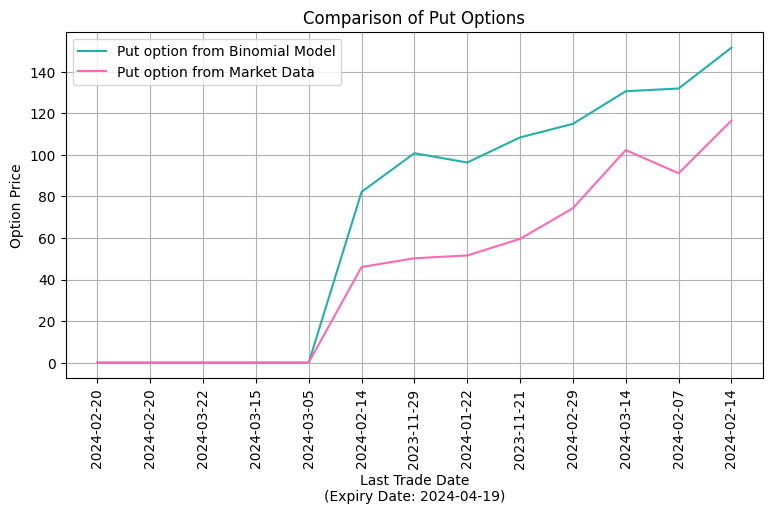

In [51]:
plt.figure(figsize=(9, 4.5))
plt.plot(puts.index, puts['optionPriceBinomial'], label='Put option from Binomial Model', c='lightseagreen')
plt.plot(puts.index, puts['lastPrice'], label='Put option from Market Data', c='hotpink')
plt.title('Comparison of Put Options')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(puts.index, puts.lastTradeDate, rotation='vertical')
plt.ylabel('Option Price')
plt.grid(True)
plt.legend()
plt.show()

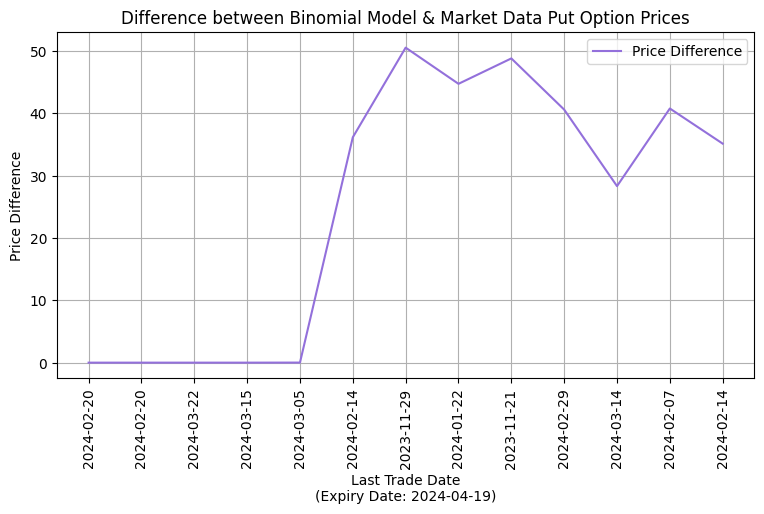

In [52]:
differences = abs(puts['optionPriceBinomial'] - puts['lastPrice'])
plt.figure(figsize=(9, 4.5))
plt.plot(puts.index, differences, label='Price Difference',  c='mediumpurple')
plt.title('Difference between Binomial Model & Market Data Put Option Prices')
plt.ylabel('Price Difference')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(puts.index, puts.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

In [53]:
option_price_black_scholes = []
for i in range(len(puts)):
    T = puts['maturityPeriod'][i]/365
    n = puts['maturityPeriod'][i]
    K = puts['strike'][i]
    S0 = puts['initialPrice'][i]
    op_price = black_scholes_formula(S0, K, T, r, σ, "put")
    option_price_black_scholes.append(op_price)

In [54]:
puts['optionPriceBlackScholes'] = option_price_black_scholes
puts.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initialPrice,maturityPeriod,optionPriceBinomial,optionPriceBlackScholes
0,2024-02-20,20.0,0.01,0.500005,REGULAR,USD,141.119995,59,0.000000e+00,7.105427e-15
1,2024-02-20,65.0,0.01,3.437501,REGULAR,USD,141.119995,59,5.487347e-16,3.836931e-13
2,2024-03-22,70.0,0.01,0.500005,REGULAR,USD,150.770004,28,0.000000e+00,1.421085e-14
3,2024-03-15,75.0,0.01,2.750003,REGULAR,USD,141.179993,35,0.000000e+00,4.263256e-14
4,2024-03-05,85.0,0.02,2.531254,REGULAR,USD,132.669998,45,5.496564e-07,1.941014e-06


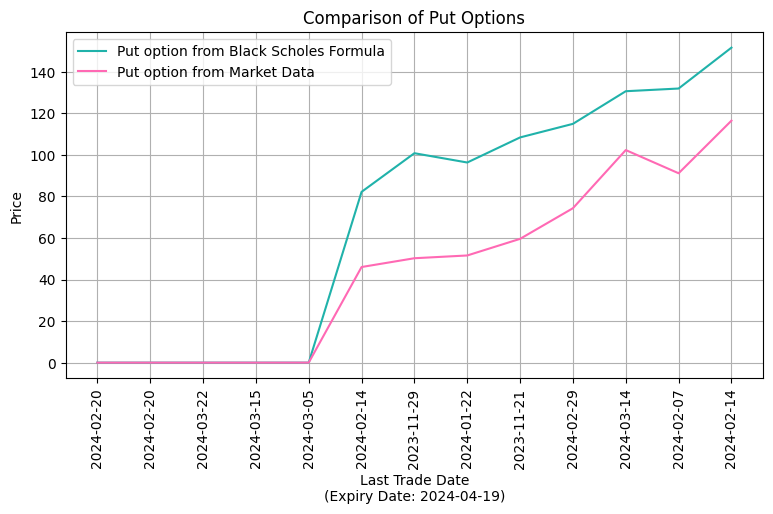

In [55]:
plt.figure(figsize=(9, 4.5))
plt.plot(puts.index, puts['optionPriceBinomial'], label='Put option from Black Scholes Formula', c='lightseagreen')
plt.plot(puts.index, puts['lastPrice'], label='Put option from Market Data', c='hotpink')
plt.title('Comparison of Put Options')
plt.ylabel('Price')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(puts.index, puts.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

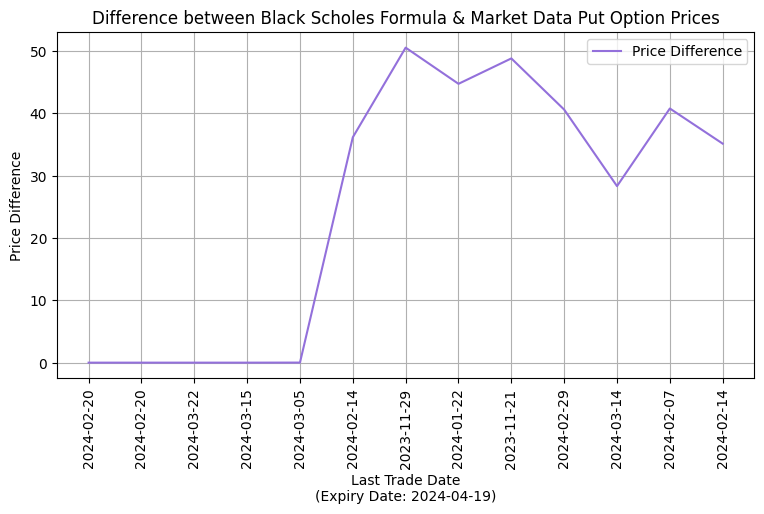

In [56]:
differences = abs(puts['optionPriceBlackScholes'] - puts['lastPrice'])
plt.figure(figsize=(9, 4.5))
plt.plot(puts.index, differences, label='Price Difference', c='mediumpurple')
plt.title('Difference between Black Scholes Formula & Market Data Put Option Prices')
plt.ylabel('Price Difference')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(puts.index, puts.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

## Black Scholes vs Binomial vs Actual Market Data

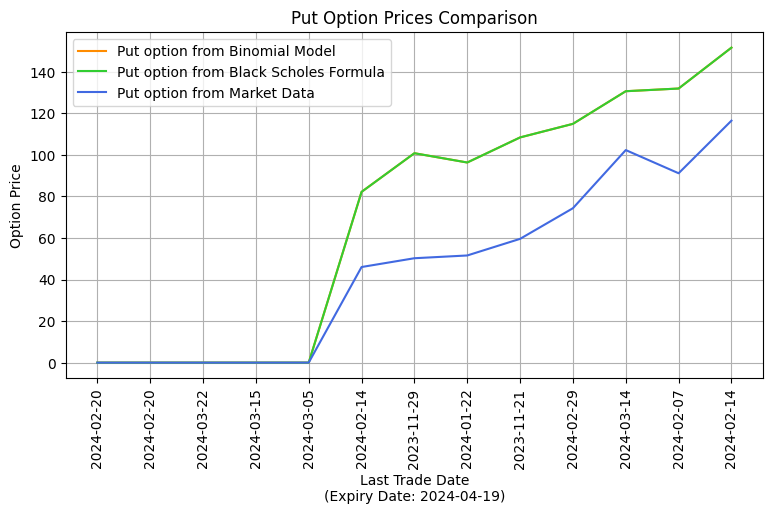

In [57]:
plt.figure(figsize=(9, 4.5))
plt.plot(puts.index, puts['optionPriceBinomial'], label='Put option from Binomial Model', c='darkorange')
plt.plot(puts.index, puts['optionPriceBlackScholes'], label='Put option from Black Scholes Formula', c='limegreen')
plt.plot(puts.index, puts['lastPrice'], label='Put option from Market Data', c='royalblue')
plt.title('Put Option Prices Comparison')
plt.ylabel('Option Price')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(puts.index, puts.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

In [58]:
def portfolio(S0, K, T, r, sigma, option='call', batch_size = 10):
    d1 = (np.log(S0 / K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    curr_delta = delta * batch_size

    if option == 'call':
        x = (batch_size * delta) / (1 - delta)
    elif option == 'put':
        x = (batch_size * (1 - delta)) / delta
        delta = delta - 1

    return x , delta

In [59]:
portfolio_call, delta_call = [], []
for i in range(len(calls)):
    date = calls.loc[i, 'lastTradeDate']
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initialPrice = google_data.loc[date, 'Close']
    temp = portfolio(initialPrice, calls.loc[i, 'strike'], calls.loc[i, 'maturityPeriod'], r, σ, option='call')
    portfolio_call.append(temp[0])
    delta_call.append(temp[1])

portfolio_put, delta_put = [], []
for i in range(len(puts)):
    date = puts.loc[i, 'lastTradeDate']
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initialPrice = google_data.loc[date, 'Close']
    temp = portfolio(initialPrice, puts.loc[i, 'strike'], puts.loc[i, 'maturityPeriod'], r, σ, option='put')
    portfolio_put.append(temp[0])
    delta_put.append(temp[1])

In [60]:
call_table = pd.DataFrame({
    'Strike (K)': calls['strike'],
    'Time to Maturity (T in days)': calls['maturityPeriod'],
    'Risk-Free Rate (r)': r,
    'Volatility (σ)': σ,
    'Call Delta': delta_call,
    'Portfolio (number of put options)': portfolio_call
})
call_table

,Strike (K),Time to Maturity (T in days),Risk-Free Rate (r),Volatility (σ),Call Delta,Portfolio (number of put options)
0,10.0,23,0.0452,0.270009,0.999804,51133.532363
1,30.0,23,0.0452,0.270009,0.996508,2854.013281
2,55.0,36,0.0452,0.270009,0.991906,1225.559216
3,60.0,23,0.0452,0.270009,0.984705,643.801058
4,70.0,37,0.0452,0.270009,0.988108,830.866728
5,90.0,65,0.0452,0.270009,0.996094,2550.490273
6,255.0,36,0.0452,0.270009,0.927557,128.038929
7,265.0,32,0.0452,0.270009,0.907890,98.565856
8,270.0,22,0.0452,0.270009,0.831264,49.264156
9,275.0,29,0.0452,0.270009,0.885038,76.984993


In [61]:
call_table = call_table.applymap('{:.6f}'.format)
call_table

,Strike (K),Time to Maturity (T in days),Risk-Free Rate (r),Volatility (σ),Call Delta,Portfolio (number of put options)
0,10.000000,23.000000,0.045200,0.270009,0.999804,51133.532363
1,30.000000,23.000000,0.045200,0.270009,0.996508,2854.013281
2,55.000000,36.000000,0.045200,0.270009,0.991906,1225.559216
3,60.000000,23.000000,0.045200,0.270009,0.984705,643.801058
4,70.000000,37.000000,0.045200,0.270009,0.988108,830.866728
5,90.000000,65.000000,0.045200,0.270009,0.996094,2550.490273
6,255.000000,36.000000,0.045200,0.270009,0.927557,128.038929
7,265.000000,32.000000,0.045200,0.270009,0.907890,98.565856
8,270.000000,22.000000,0.045200,0.270009,0.831264,49.264156
9,275.000000,29.000000,0.045200,0.270009,0.885038,76.984993


In [62]:
put_data = pd.DataFrame({
    'Strike (K)': puts['strike'],
    'Time to Maturity (T in days)': puts['maturityPeriod'],
    'Risk-Free Rate (r)': r,
    'Volatility (σ)': σ,
    'Put Delta': delta_put,
    'Portfolio (number of call options)': portfolio_put
})
put_data

,Strike (K),Time to Maturity (T in days),Risk-Free Rate (r),Volatility (σ),Put Delta,Portfolio (number of call options)
0,20.0,59,0.0452,0.270009,-0.000547,0.005478
1,65.0,59,0.0452,0.270009,-0.003502,0.035147
2,70.0,28,0.0452,0.270009,-0.016291,0.165608
3,75.0,35,0.0452,0.270009,-0.014443,0.146544
4,85.0,45,0.0452,0.270009,-0.011471,0.116039
5,230.0,65,0.0452,0.270009,-0.012903,0.130717
6,240.0,142,0.0452,0.270009,-0.000308,0.003078
7,245.0,88,0.0452,0.270009,-0.004239,0.042569
8,250.0,150,0.0452,0.270009,-0.000214,0.002144
9,255.0,50,0.0452,0.270009,-0.034495,0.357277


In [63]:
put_data = put_data.applymap('{:.6f}'.format)
put_data

,Strike (K),Time to Maturity (T in days),Risk-Free Rate (r),Volatility (σ),Put Delta,Portfolio (number of call options)
0,20.000000,59.000000,0.045200,0.270009,-0.000547,0.005478
1,65.000000,59.000000,0.045200,0.270009,-0.003502,0.035147
2,70.000000,28.000000,0.045200,0.270009,-0.016291,0.165608
3,75.000000,35.000000,0.045200,0.270009,-0.014443,0.146544
4,85.000000,45.000000,0.045200,0.270009,-0.011471,0.116039
5,230.000000,65.000000,0.045200,0.270009,-0.012903,0.130717
6,240.000000,142.000000,0.045200,0.270009,-0.000308,0.003078
7,245.000000,88.000000,0.045200,0.270009,-0.004239,0.042569
8,250.000000,150.000000,0.045200,0.270009,-0.000214,0.002144
9,255.000000,50.000000,0.045200,0.270009,-0.034495,0.357277


---
## Implied Volatility
---

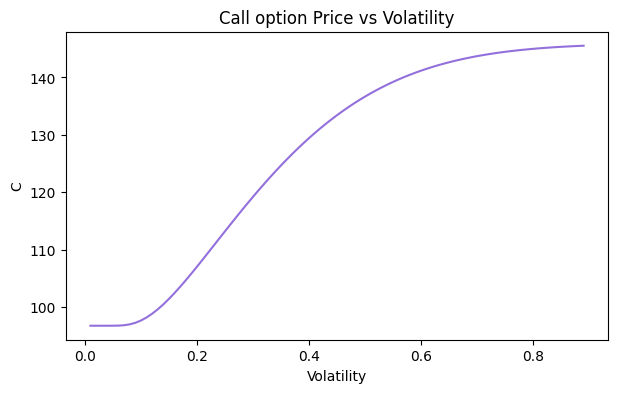

In [64]:
σs = np.arange(0.01, 0.9, 0.01)
C = [black_scholes_formula(S0, K, 40, r, σ, "call") for σ in σs]

plt.figure(figsize=(7, 4))
plt.plot(σs, C, c='mediumpurple')
plt.title("Call option Price vs Volatility")
plt.xlabel("Volatility")
plt.ylabel("C")
plt.show()

In [65]:
def newton_raphson(function, initial_guess, tolerance=1e-6, max_iterations=100, dh=1e-6):
    '''
    finds root of a function using newton-raphson method
    '''
    x = initial_guess
    for _ in range(max_iterations):
        fx = function(x)
        if abs(fx) < tolerance:
            return x
        dfx = (function(x + dh) - function(x)) / dh
        if dfx == 0:
            break
        x = x - fx / (dfx + 1e-6)
        if x < 0:
            x = dh
    return x

In [66]:
def implied_volatitlity(S0, K, r, T, CP, option='call'):
    def H(σ):
        return (black_scholes_formula(S0, K, T, r, σ, option) - CP)**2

    val = newton_raphson(H, 1.0)
    if np.abs(H(val) - H(0.0)) < 1e-5:
        return 0.0
    return val * 100

In [67]:
call_volatility = []
for i in range(len(calls)):
    date = calls.loc[i, 'lastTradeDate']
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initialPrice = google_data.loc[date, 'Close']
    temp = implied_volatitlity(initialPrice, calls.loc[i, 'strike'], r, calls.loc[i, 'maturityPeriod']/365, calls.loc[i, 'lastPrice'], option='call')
    call_volatility.append(temp)
    
put_volatility = []
for i in range(1, len(puts)):
    date = puts.loc[i, 'lastTradeDate']
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initialPrice = google_data.loc[date, 'Close']
    temp = implied_volatitlity(initialPrice, puts.loc[i, 'strike'], r, puts.loc[i, 'maturityPeriod']/365, puts.loc[i, 'lastPrice'], option='put')
    put_volatility.append(temp)

In [68]:
call_data = calls[['strike', 'lastPrice', 'maturityPeriod']].copy()
call_data.rename(columns={'strike': 'K', 'lastPrice': 'C', 'maturityPeriod': 'T'}, inplace=True)
call_data['S0'] = [google_data.loc[pd.to_datetime(date).strftime("%Y-%m-%d"), 'Close'] for date in calls['lastTradeDate']]
call_data['r'] = r
call_data['Implied Volatility(%)'] = call_volatility

In [69]:
call_data

,K,C,T,S0,r,Implied Volatility(%)
0,10.0,163.00,23,150.869995,0.0452,0.000000
1,30.0,142.65,23,150.869995,0.0452,0.000000
2,55.0,118.80,36,143.100006,0.0452,15054.350497
3,60.0,112.60,23,150.869995,0.0452,101407.256725
4,70.0,101.60,37,139.789993,0.0452,0.000000
5,90.0,94.81,65,145.940002,0.0452,351.242648
6,255.0,0.02,36,143.100006,0.0452,63.006280
7,265.0,0.01,32,147.679993,0.0452,63.770677
8,270.0,0.01,22,150.929993,0.0452,76.437223
9,275.0,0.01,29,147.600006,0.0452,70.822997


In [70]:
put_data = puts[['strike', 'lastPrice', 'maturityPeriod']].iloc[1:, :].copy()
put_data.rename(columns={'strike': 'K', 'lastPrice': 'P', 'maturityPeriod': 'T'}, inplace=True)
put_data['S0'] = [google_data.loc[pd.to_datetime(date).strftime("%Y-%m-%d"), 'Close'] for date in puts['lastTradeDate'].iloc[1:]]
put_data['r'] = r
put_data['Implied Volatility(%)'] = put_volatility

In [71]:
put_data

,K,P,T,S0,r,Implied Volatility(%)
1,65.0,0.01,59,141.119995,0.0452,65.744747
2,70.0,0.01,28,150.770004,0.0452,93.169793
3,75.0,0.01,35,141.179993,0.0452,70.018986
4,85.0,0.02,45,132.669998,0.0452,48.041383
5,230.0,46.04,65,145.940002,0.0452,0.000000
6,240.0,50.27,142,134.990005,0.0452,0.000000
7,245.0,51.60,88,145.990005,0.0452,0.000000
8,250.0,59.60,150,136.970001,0.0452,0.000000
9,255.0,74.35,50,138.460007,0.0452,0.000000
10,275.0,102.34,36,143.100006,0.0452,0.000000


---